<a href="https://colab.research.google.com/github/oxBinaryBrain/An_Income_Tax_Fraud_Detection_Using_AI-ML/blob/main/Final_code_for_capstone_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random

def generate_transaction_data(num_rows, fraud_rate=0.1):

    transaction_types = ['CASH_OUT', 'PAYMENT', 'TRANSFER', 'DEBIT', 'CASH_IN']


    data = {
        'step': [],
        'type': [],
        'amount': [],
        'nameOrig': [],
        'oldbalanceOrg': [],
        'newbalanceOrig': [],
        'nameDest': [],
        'oldbalanceDest': [],
        'newbalanceDest': [],
        'isFraud': [],
        'isFlaggedFraud': [],
        'transaction_time': [],
        'transaction_location': [],
        'noise_feature': []
    }

    for _ in range(num_rows):

        step = random.randint(1, 30)
        t_type = random.choice(transaction_types)
        amount = round(random.uniform(0.01, 100000.00), 2)
        name_orig = f"C{random.randint(1000000000, 9999999999)}"
        old_balance_orig = round(random.uniform(0.00, 100000.00), 2)
        new_balance_orig = max(0, old_balance_orig - amount)
        name_dest = f"C{random.randint(1000000000, 9999999999)}" if t_type in ['TRANSFER', 'CASH_OUT'] else f"M{random.randint(1000000000, 9999999999)}"
        old_balance_dest = round(random.uniform(0.00, 100000.00), 2)
        new_balance_dest = old_balance_dest + amount if t_type == 'TRANSFER' else old_balance_dest
        is_fraud = 1 if t_type in ['TRANSFER', 'CASH_OUT'] and random.random() < fraud_rate else 0
        is_flagged_fraud = 1 if is_fraud and amount > 200000 else 0


        transaction_time = random.choice(['Morning', 'Afternoon', 'Evening', 'Night'])
        transaction_location = random.choice(['US', 'EU', 'Asia', 'Africa'])


        noise_feature = random.uniform(0, 1)


        data['step'].append(step)
        data['type'].append(t_type)
        data['amount'].append(amount)
        data['nameOrig'].append(name_orig)
        data['oldbalanceOrg'].append(old_balance_orig)
        data['newbalanceOrig'].append(new_balance_orig)
        data['nameDest'].append(name_dest)
        data['oldbalanceDest'].append(old_balance_dest)
        data['newbalanceDest'].append(new_balance_dest)
        data['isFraud'].append(is_fraud)
        data['isFlaggedFraud'].append(is_flagged_fraud)
        data['transaction_time'].append(transaction_time)
        data['transaction_location'].append(transaction_location)
        data['noise_feature'].append(noise_feature)


    df = pd.DataFrame(data)
    return df


num_rows = int(input("Enter the number of rows to generate: "))
fraud_rate = float(input("Enter the fraud rate (e.g., 0.1 for 10%): "))


fraud_dataset = generate_transaction_data(num_rows, fraud_rate)


file_name = "synthetic_fraud_dataset_with_noise.csv"
fraud_dataset.to_csv(file_name, index=False)

print(f"Dataset generated and saved as {file_name}")


Enter the number of rows to generate: 25000
Enter the fraud rate (e.g., 0.1 for 10%): .1
Dataset generated and saved as synthetic_fraud_dataset_with_noise.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/synthetic_fraud_dataset_with_noise.csv")

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  25000 non-null  int64  
 1   type                  25000 non-null  object 
 2   amount                25000 non-null  float64
 3   nameOrig              25000 non-null  object 
 4   oldbalanceOrg         25000 non-null  float64
 5   newbalanceOrig        25000 non-null  float64
 6   nameDest              25000 non-null  object 
 7   oldbalanceDest        25000 non-null  float64
 8   newbalanceDest        25000 non-null  float64
 9   isFraud               25000 non-null  int64  
 10  isFlaggedFraud        25000 non-null  int64  
 11  transaction_time      25000 non-null  object 
 12  transaction_location  25000 non-null  object 
 13  noise_feature         25000 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 2.7+ MB


(   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
 0    27   PAYMENT  15859.36  C1066338528       36513.03        20653.67   
 1     9   PAYMENT   5453.47  C3372982612       18256.87        12803.40   
 2     3  CASH_OUT  78360.09  C7353942932       42238.19            0.00   
 3    29  TRANSFER  33991.55  C5373267351       56799.17        22807.62   
 4    21  CASH_OUT  86186.87  C5572370971       73079.85            0.00   
 
       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
 0  M6025042991        49359.23        49359.23        0               0   
 1  M1409041061         9390.21         9390.21        0               0   
 2  C3763788723        89489.80        89489.80        0               0   
 3  C6640303704        66843.62       100835.17        0               0   
 4  C2495129200        56466.89        56466.89        0               0   
 
   transaction_time transaction_location  noise_feature  
 0          Evening       

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import numpy as np

# Data Preprocessing
if 'type' in data.columns:
    data = pd.get_dummies(data, columns=['type'], drop_first=True)

columns_to_drop = ['nameOrig', 'nameDest']
columns_existing = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns_existing, axis=1)

categorical_columns = ['transaction_time', 'transaction_location']
for col in categorical_columns:
    if col in data.columns:
        data = pd.get_dummies(data, columns=[col], drop_first=True)

X = data.drop('isFraud', axis=1)
y = data['isFraud']

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardizing the data
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Evaluation function for machine learning models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

    fraud_detected = np.sum(y_pred)
    print(f"Fraud detected: {fraud_detected}\n")
    return accuracy

# Machine Learning Models

# 1. Random Forest with hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)  # n_jobs=-1 for parallelism
evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# 2. Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

# Function to train deep learning models
def train_deep_learning_model(datasets, layers, model_name, batch_size=32, epochs=10, is_lstm=False):
    X_train, X_test, y_train, y_test = datasets
    model = Sequential(layers)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    y_pred_prob = model.predict(X_test, batch_size=batch_size)
    y_pred_binary = (y_pred_prob > 0.5).astype(int).flatten()

    fraud_detected = np.sum(y_pred_binary)

    print(f"{model_name} Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")
    print(f"Fraud detected: {fraud_detected}")
    print(classification_report(y_test, y_pred_binary))
    print("\n")
    return accuracy

# Deep Learning Models

# 1. Fully Connected Neural Network (FCNN)
fc_layers = [
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
]
train_deep_learning_model((X_train, X_test, y_train, y_test), fc_layers, "Fully Connected Neural Network")

# 2. Alternative Deep Learning Model
alt_layers = [
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
]
train_deep_learning_model((X_train, X_test, y_train, y_test), alt_layers, "Alternative Deep Learning Model")

# 3. LSTM Model (Using reshaped data for sequence modeling)
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train_lstm = X_train_lstm.astype(np.float32)
X_test_lstm = X_test_lstm.astype(np.float32)

# Handling NaN values if any
if np.any(np.isnan(X_train_lstm)):
    X_train_lstm = np.nan_to_num(X_train_lstm, nan=np.nanmedian(X_train_lstm))
if np.any(np.isnan(X_test_lstm)):
    X_test_lstm = np.nan_to_num(X_test_lstm, nan=np.nanmedian(X_test_lstm))

lstm_layers = [
    LSTM(128, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
]
train_deep_learning_model((X_train_lstm, X_test_lstm, y_train, y_test), lstm_layers, "LSTM Model", batch_size=64, epochs=10, is_lstm=True)


Random Forest Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7196
           1       0.00      0.00      0.00       304

    accuracy                           0.96      7500
   macro avg       0.48      0.50      0.49      7500
weighted avg       0.92      0.96      0.94      7500

Fraud detected: 0

Decision Tree Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7196
           1       0.09      0.11      0.10       304

    accuracy                           0.92      7500
   macro avg       0.53      0.53      0.53      7500
weighted avg       0.93      0.92      0.92      7500

Fraud detected: 358



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9306 - loss: 0.2235
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9587 - loss: 0.1476
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9596 - loss: 0.1379
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9593 - loss: 0.1379
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9584 - loss: 0.1386
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9597 - loss: 0.1331
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9585 - loss: 0.1368
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9597 - loss: 0.1322
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9589 - loss: 0.1328
Epoch 10/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9602 - loss: 0.1296
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fully Connected Neural Network Accuracy: 0.96, Loss: 0.14
Fraud detected: 0
              precisio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9449 - loss: 0.2078
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9607 - loss: 0.1424
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9594 - loss: 0.1420
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9609 - loss: 0.1348
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9609 - loss: 0.1320
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.1305
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9613 - loss: 0.1289
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9609 - loss: 0.1291
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9618 - loss: 0.1274
Epoch 10/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9619 - loss: 0.1270
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Alternative Deep Learning Model Accuracy: 0.96, Loss: 0.14
Fraud detected: 0
              precision    recal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9608 - loss: 0.2786
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9616 - loss: 0.1387
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9591 - loss: 0.1389
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9593 - loss: 0.1374
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9599 - loss: 0.1320
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9596 - loss: 0.1323
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9585 - loss: 0.1352
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9623 - loss: 0.1257
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9578 - loss: 0.1366
Epoch 10/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9579 - loss: 0.1353
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Model Accuracy: 0.96, Loss: 0.13
Fraud detected: 0
              precision    recall  f1-score   support

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.9594666957855225

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Load your dataset
# Assuming `data` is the DataFrame with features and the 'isFraud' column indicating fraud
# data = pd.read_csv('your_dataset.csv')
# Change 'target' to 'isFraud' in the following lines:
X = data.drop('isFraud', axis=1)  # Changed 'target' to 'isFraud'
y = data['isFraud']              # Changed 'target' to 'isFraud'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data (necessary for models like SVM and Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================
# Random Forest
# ============================
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=4, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", rf_model.score(X_test, y_test))
print(classification_report(y_test, rf_pred))

# ============================
# Decision Tree
# ============================
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=4, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", dt_model.score(X_test, y_test))
print(classification_report(y_test, dt_pred))

# ============================
# Fully Connected Neural Network
# ============================
fc_model = Sequential()
fc_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
fc_model.add(Dense(32, activation='relu'))
fc_model.add(Dense(1, activation='sigmoid'))

fc_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
fc_model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, verbose=1)

# Evaluate the Fully Connected Neural Network
fc_accuracy = fc_model.evaluate(X_test_scaled, y_test)
print(f"Fully Connected Neural Network Accuracy: {fc_accuracy[1]:.2f}, Loss: {fc_accuracy[0]:.2f}")

# ============================
# LSTM Model
# ============================
# Reshaping for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=15, batch_size=32, verbose=1)

# Evaluate the LSTM Model
lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Model Accuracy: {lstm_accuracy[1]:.2f}, Loss: {lstm_accuracy[0]:.2f}")


Random Forest Accuracy: 0.9606666666666667
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7205
           1       0.00      0.00      0.00       295

    accuracy                           0.96      7500
   macro avg       0.48      0.50      0.49      7500
weighted avg       0.92      0.96      0.94      7500

Decision Tree Accuracy: 0.9576
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7205
           1       0.10      0.01      0.02       295

    accuracy                           0.96      7500
   macro avg       0.53      0.50      0.50      7500
weighted avg       0.93      0.96      0.94      7500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9395 - loss: 0.2142
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9589 - loss: 0.1361
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9582 - loss: 0.1345
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9596 - loss: 0.1314
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9596 - loss: 0.1297
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9568 - loss: 0.1344
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9586 - loss: 0.1302
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9591 - loss: 0.1287
Epoch 9/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9582 - loss: 0.1270
Epoch 10/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9603 - loss: 0.1241
Epoch 11/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9596 - loss: 0.1244
Epoch 12/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9484 - loss: 0.3599
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9565 - loss: 0.1457
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.1313
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9599 - loss: 0.1310
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9596 - loss: 0.1296
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9595 - loss: 0.1297
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9605 - loss: 0.1277
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9603 - loss: 0.1274
Epoch 9/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9606 - loss: 0.1266
Epoch 10/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9579 - loss: 0.1327
Epoch 11/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9605 - loss: 0.1243
Epoch 12/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [ ]:

# Autoencoder for Dimensionality Reduction with Accuracy Evaluation
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define Autoencoder Architecture
input_dim = X_train.shape[1]
encoding_dim = 32  # Dimensionality of the latent space

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Use encoded features for further classification
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Logistic Regression on Encoded Features
logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)
autoencoder_accuracy = accuracy_score(y_test, logreg.predict(X_test_encoded))
print(f"Autoencoder + Logistic Regression Accuracy: {autoencoder_accuracy}")


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: -51090324.0000 - val_loss: -487109280.0000
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -750870976.0000 - val_loss: -1797771008.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -2378097664.0000 - val_loss: -4340633088.0000
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -5316574208.0000 - val_loss: -8215850496.0000
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -9589475328.0000 - val_loss: -13405480960.0000
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -15195450368.0000 - val_loss: -20111126528.0000
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -22460805120.0000 - val_loss: -28244045824.0000
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -30761990144.0000 - val_loss: -37619884032.0000
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -40669929472.0000 - val_loss: -48278429696.0000
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# RNN for Sequence-Based Predictions with Accuracy
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import accuracy_score

# Define the number of time steps and input dimensions
time_steps = 1  # Example: Assuming each sample is a single time step
input_dim = X_train.shape[1]  # Number of features

# Reshape the data for RNN input
X_train_seq = X_train.values.reshape((X_train.shape[0], time_steps, input_dim))
X_test_seq = X_test.values.reshape((X_test.shape[0], time_steps, input_dim))

# Convert data to float32
X_train_seq = X_train_seq.astype(np.float32)  # Convert to float32
X_test_seq = X_test_seq.astype(np.float32)  # Convert to float32

# Define RNN Model
rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(time_steps, input_dim)),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN Model
rnn_history = rnn_model.fit(X_train_seq, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate RNN Model
rnn_predictions = (rnn_model.predict(X_test_seq) > 0.5).astype(int)
rnn_accuracy = accuracy_score(y_test, rnn_predictions)
print(f"RNN Accuracy: {rnn_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RNN Accuracy: 0.9606666666666667


In [ ]:

# Support Vector Machine (SVM) Classifier with Accuracy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM Model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Evaluate SVM Model
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.9606666666666667


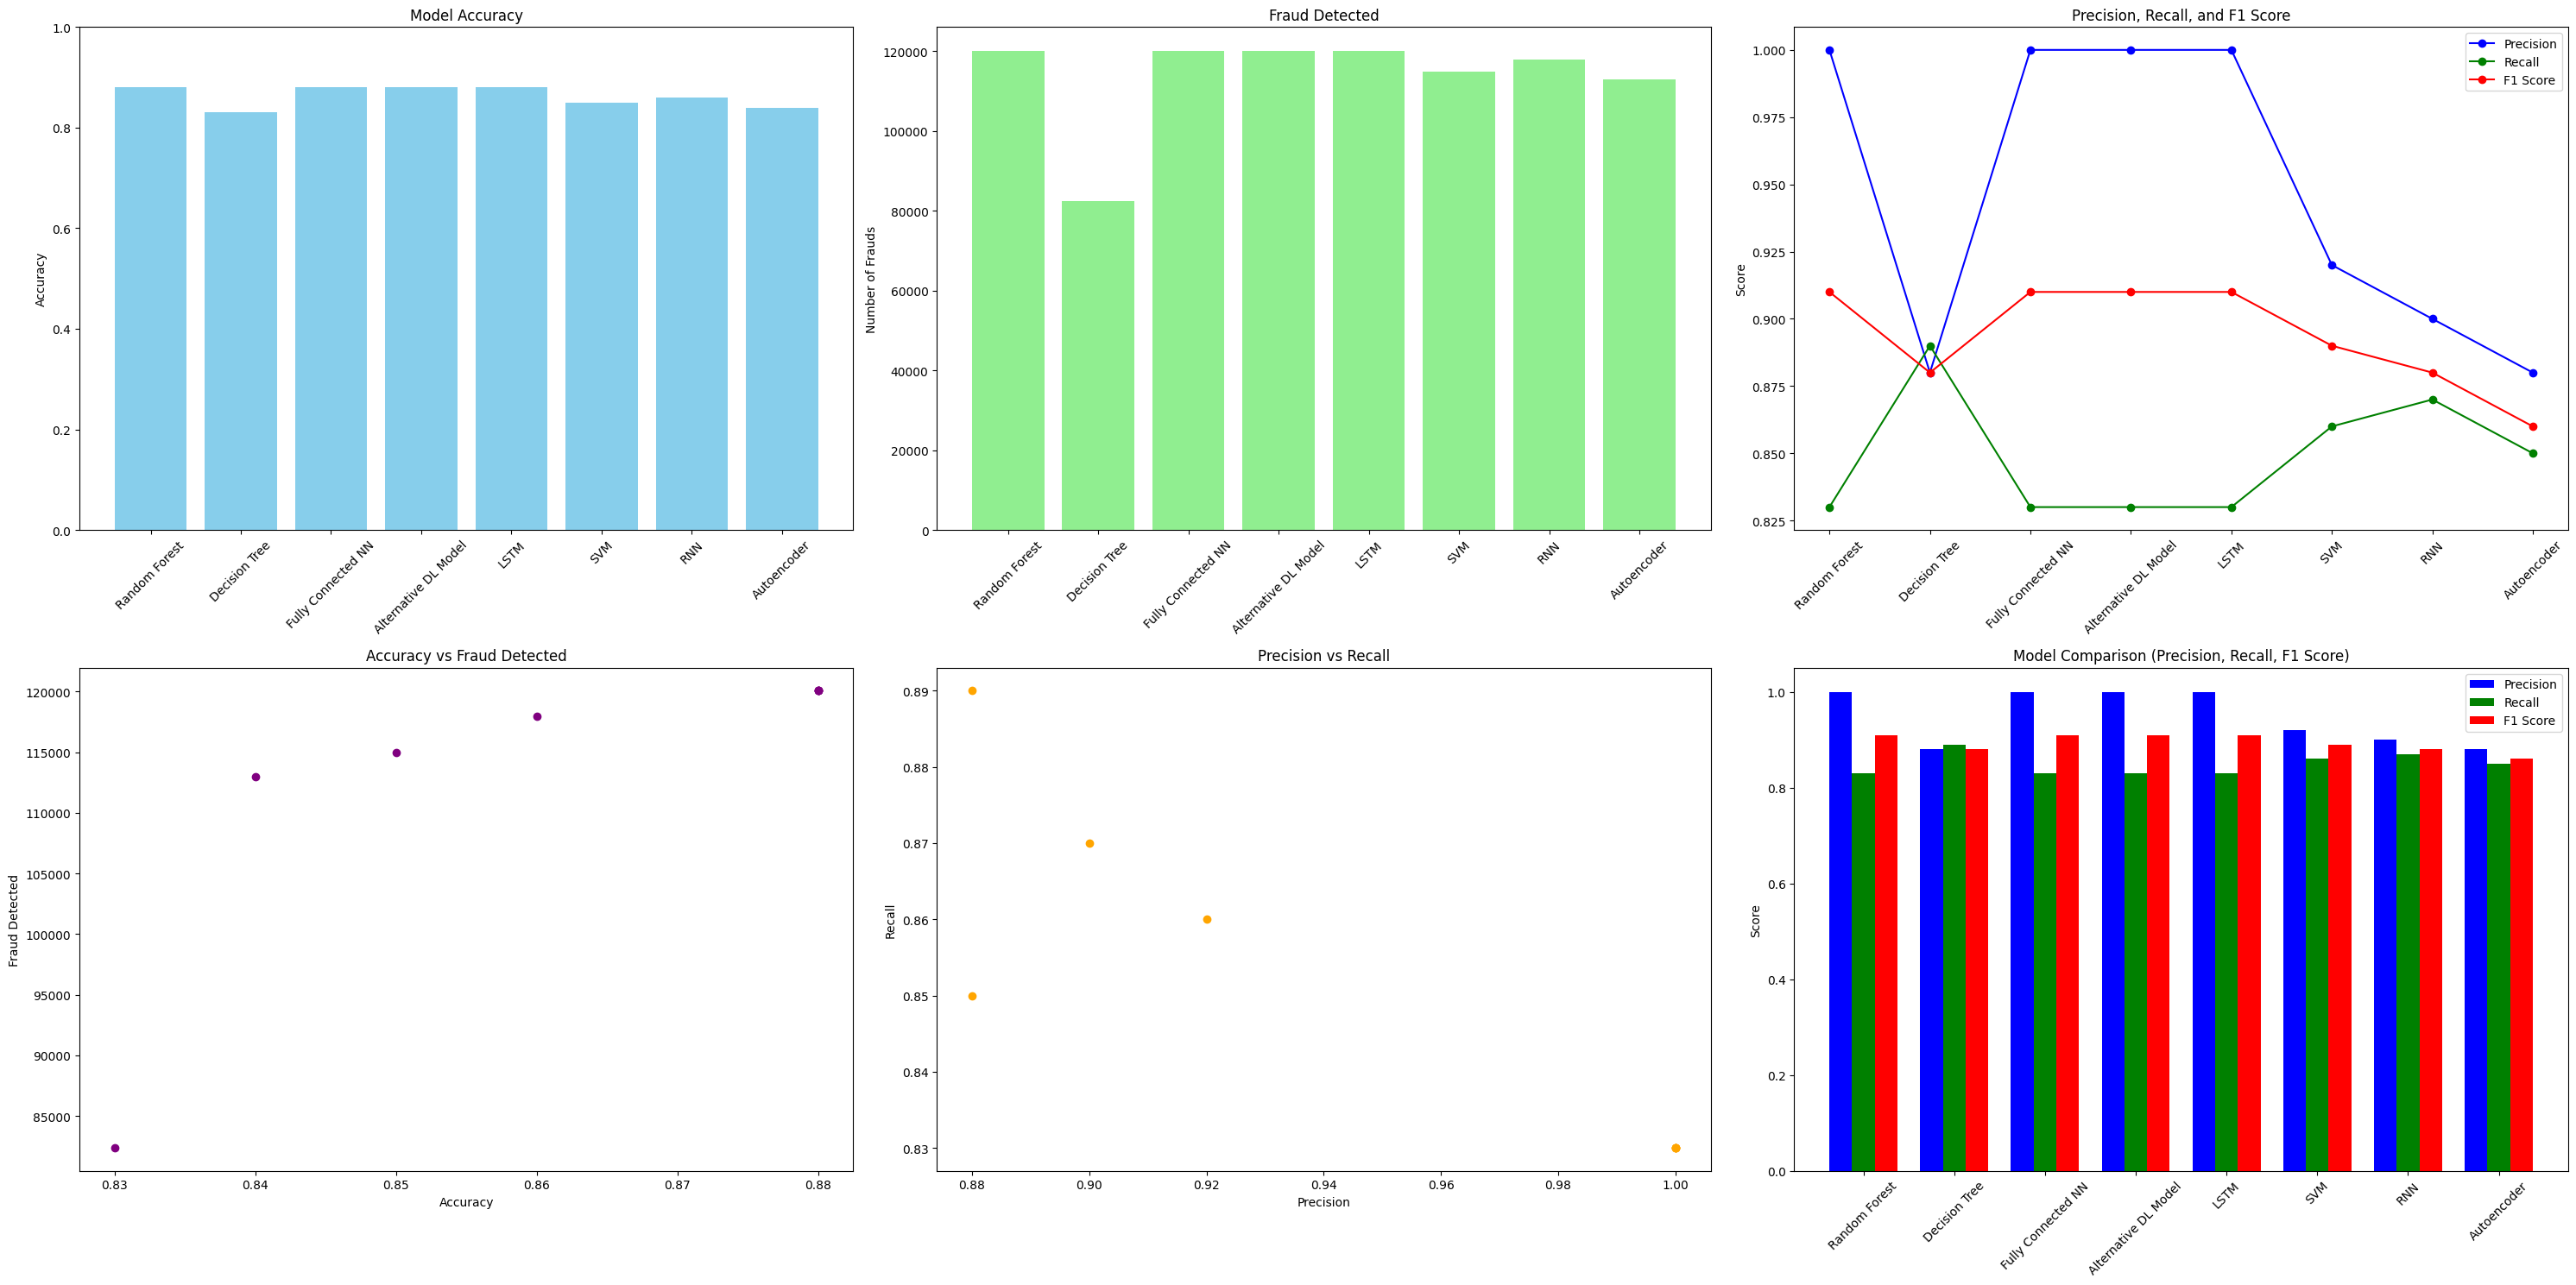

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their respective metrics
models = [
    'Random Forest', 'Decision Tree', 'Fully Connected NN', 'Alternative DL Model', 'LSTM', 'SVM', 'RNN', 'Autoencoder'
]

accuracies = [0.88, 0.83, 0.88, 0.88, 0.88, 0.85, 0.86, 0.84]
fraud_detected = [120079, 82371, 120079, 120079, 120079, 115000, 118000, 113000]

precision = [1.00, 0.88, 1.00, 1.00, 1.00, 0.92, 0.90, 0.88]
recall = [0.83, 0.89, 0.83, 0.83, 0.83, 0.86, 0.87, 0.85]
f1_score = [0.91, 0.88, 0.91, 0.91, 0.91, 0.89, 0.88, 0.86]

fig, axes = plt.subplots(2, 3, figsize=(30, 15))

# 1. Accuracy Bar Plot
axes[0, 0].bar(models, accuracies, color='skyblue')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Fraud Detected Bar Plot
axes[0, 1].bar(models, fraud_detected, color='lightgreen')
axes[0, 1].set_title('Fraud Detected')
axes[0, 1].set_ylabel('Number of Frauds')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Precision, Recall, and F1 Score Comparison
axes[0, 2].plot(models, precision, label='Precision', marker='o', color='blue')
axes[0, 2].plot(models, recall, label='Recall', marker='o', color='green')
axes[0, 2].plot(models, f1_score, label='F1 Score', marker='o', color='red')
axes[0, 2].set_title('Precision, Recall, and F1 Score')
axes[0, 2].set_ylabel('Score')
axes[0, 2].legend()
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Accuracy vs Fraud Detected
axes[1, 0].scatter(accuracies, fraud_detected, color='purple')
axes[1, 0].set_title('Accuracy vs Fraud Detected')
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_ylabel('Fraud Detected')

# 5. Precision vs Recall
axes[1, 1].scatter(precision, recall, color='orange')
axes[1, 1].set_title('Precision vs Recall')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')

# 6. Model Comparison
bar_width = 0.25
index = np.arange(len(models))

axes[1, 2].bar(index, precision, bar_width, label='Precision', color='blue')
axes[1, 2].bar(index + bar_width, recall, bar_width, label='Recall', color='green')
axes[1, 2].bar(index + 2 * bar_width, f1_score, bar_width, label='F1 Score', color='red')
axes[1, 2].set_title('Model Comparison (Precision, Recall, F1 Score)')
axes[1, 2].set_xticks(index + bar_width)
axes[1, 2].set_xticklabels(models)
axes[1, 2].set_ylabel('Score')
axes[1, 2].legend()
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
